# Hierarchical Forecast Networks

This notebook offers a step by step guide to create a hierarchical forecasting pipeline.

In the pipeline we will use `NeuralForecast` and `HINT` class, to create fit, predict and reconcile forecasts.

We will use the TourismL dataset that summarizes large Australian national visitor survey.

Outline<br>
1. Installing packages<br>
2. Load hierarchical dataset<br>
3. Fit and Predict HINT<br>
4. Forecast Evaluation

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/HierarchicalNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing packages

In [ ]:
%%capture
!pip install git+https://github.com/Nixtla/neuralforecast.git

In [ ]:
%%capture
!pip install datasetsforecast hierarchicalforecast

## 2. Load hierarchical dataset

This detailed Australian Tourism Dataset comes from the National Visitor Survey, managed by the Tourism Research Australia, it is composed of 555 monthly series from 1998 to 2016, it is organized geographically, and purpose of travel. The natural geographical hierarchy comprises seven states, divided further in 27 zones and 76 regions. The purpose of travel categories are holiday, visiting friends and relatives (VFR), business and other. The MinT (Wickramasuriya et al., 2019), among other hierarchical forecasting studies has used the dataset it in the past. The dataset can be accessed in the [MinT reconciliation webpage](https://robjhyndman.com/publications/mint/), although other sources are available.

| Geographical Division | Number of series per division | Number of series per purpose | Total |
|          ---          |               ---             |              ---             |  ---  |
|  Australia            |              1                |               4              |   5   |
|  States               |              7                |              28              |  35   |
|  Zones                |             27                |              108             |  135  |
|  Regions              |             76                |              304             |  380  |
|  Total                |            111                |              444             |  555  |


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from datasetsforecast.hierarchical import HierarchicalData
from hierarchicalforecast.utils import aggregate, HierarchicalPlot

from neuralforecast.utils import augment_calendar_df

def sort_df_hier(Y_df, S):
    # NeuralForecast core, sorts unique_id lexicographically
    # by default, this class matches S_df and Y_hat_df order.
    Y_df.unique_id = Y_df.unique_id.astype('category')
    Y_df.unique_id = Y_df.unique_id.cat.set_categories(S.index)
    Y_df = Y_df.sort_values(by=['unique_id', 'ds'])
    return Y_df

# Load hierarchical dataset
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismLarge')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df = sort_df_hier(Y_df, S_df)

Y_df, _ = augment_calendar_df(df=Y_df, freq='M')

Mathematically a hierarchical multivariate time series can be denoted by the vector $\mathbf{y}_{[a,b],t}$ defined by the following aggregation constraint: 
$$
\mathbf{y}_{[a,b],t}  = \mathbf{S}_{[a,b][b]} \mathbf{y}_{[b],t} \quad \Leftrightarrow \quad 
\begin{bmatrix}\mathbf{y}_{[a],t}
\\ %\hline
\mathbf{y}_{[b],t}\end{bmatrix} 
= \begin{bmatrix}
\mathbf{A}_{[a][b]}\\ %\hline
\mathbf{I}_{[b][b]}
\end{bmatrix}
\mathbf{y}_{[b],t}
$$

where $\mathbf{y}_{[a],t}$ are the aggregate series, $\mathbf{y}_{[b],t}$ are the bottom level series and $\mathbf{S}_{[a,b][b]}$ are the hierarchical aggregation constraints.

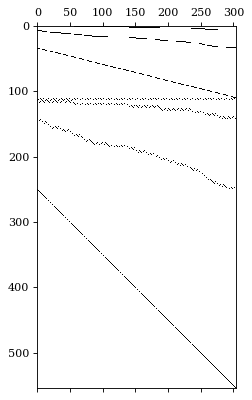

In [ ]:
# Here we plot the hierarchical constraints matrix
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

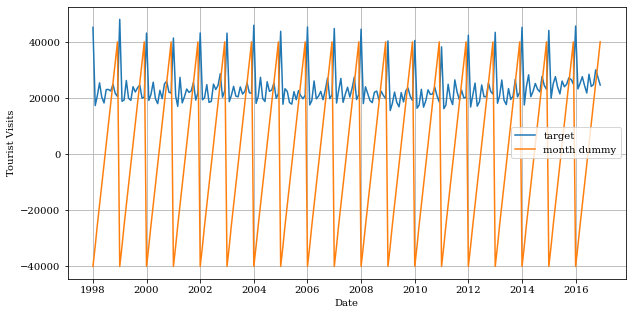

In [ ]:
# Here we plot the top most series from the dataset
# that corresponds to the total tourist monthly visits to Australia
plt.figure(figsize=(10,5))
plt.plot(Y_df[Y_df['unique_id']=='TotalAll']['ds'], 
         Y_df[Y_df['unique_id']=='TotalAll']['y'], label='target')
plt.plot(Y_df[Y_df['unique_id']=='TotalAll']['ds'], 
         Y_df[Y_df['unique_id']=='TotalAll']['month']*80000, label='month dummy')
plt.xlabel('Date')
plt.ylabel('Tourist Visits')
plt.legend()
plt.grid()
plt.show()
plt.close()

## 3. Fit and Predict HINT

The Hierarchical Forecast Network (HINT) combines into an easy to use model three components:<br>
1. SoTA deep learning models.<br> 
2. An efficient and flexible multivariate probability distribution.<br>
3. Builtin reconciliation capabilities.<br>

In [ ]:
import numpy as np

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx, NHITS, HINT
from neuralforecast.losses.pytorch import GMM

In [ ]:
# Horizon and quantiles
horizon = 12
level = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in level]
quantiles = np.sort(np.concatenate(qs)/100)

# HINT := BaseNetwork + Distribution + Reconciliation
nhits = NHITS(h=horizon,
              input_size=24,
              loss=GMM(n_components=10, quantiles=quantiles),
              hist_exog_list=['month'],
              max_steps=1000,
              early_stop_patience_steps=3,
              val_check_steps=100,
              scaler_type='robust',
              learning_rate=5e-3)

model = HINT(h=horizon, S=S_df.values,
             model=nhits,  reconciliation='MinTraceOLS')

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [ ]:
#%%capture
nf = NeuralForecast(models=[model], freq='MS')
fcsts_df = nf.cross_validation(df=Y_df, val_size=12, n_windows=1)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

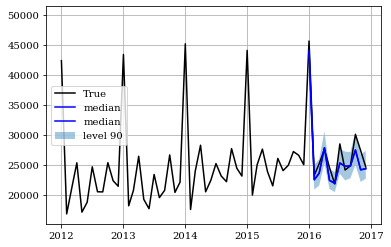

In [ ]:
unique_id = 'TotalAll'
Y_plot_df = Y_df[Y_df.unique_id==unique_id].tail(12*5)
plot_df = fcsts_df[fcsts_df.unique_id==unique_id]
plot_df = Y_plot_df.merge(plot_df, on=['ds', 'unique_id'], how='left')

plt.plot(plot_df['ds'], plot_df['y_x'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['HINT-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['HINT-lo-90.0'][-12:].values,
                 y2=plot_df['HINT-hi-90.0'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

## 4. Forecast Evaluation

To evaluate the coherent probabilistic predictions we use the scaled Continuous Ranked Probability Score (sCRPS), defined as follows:

$$\mathrm{CRPS}(\hat{F}_{[a,b],\tau},\mathbf{y}_{[a,b],\tau}) = \frac{2}{N_{a}+N_{b}} \sum_{i} \int^{1}_{0} \mathrm{QL}(\hat{F}_{i,\tau}, y_{i,\tau})_{q} dq$$

$$
\mathrm{sCRPS}(\hat{F}_{[a,b\,],\tau},\mathbf{y}_{[a,b\,],\tau}) = 
    \frac{\mathrm{CRPS}(\hat{F}_{[a,b\,],\tau},\mathbf{y}_{[a,b\,],\tau})}{\sum_{i} | y_{i,\tau} |}
$$

As you can see the HINT model efficiently achieves state of the art accuracy under minimal tuning.

In [ ]:
from hierarchicalforecast.evaluation import scaled_crps

n_series = len(S_df)
n_quantiles = len(quantiles)

# Parse y_test and y_rec
# Keep only quantile columns from fcsts_df
model_name = type(model).__name__
quantile_columns = [model_name + n for n in nhits.loss.output_names]
quantile_columns.remove(model_name + '-median')
y_rec  = fcsts_df[quantile_columns].values 
y_test = fcsts_df['y'].values

y_rec  = y_rec.reshape(n_series, horizon, n_quantiles)
y_test = y_test.reshape(n_series, horizon)
scrps  = scaled_crps(y=y_test, y_hat=y_rec, quantiles=quantiles)

print('scaled CRPS')
print(f'HINT:\t\t {np.round(scrps, 3)}')
print(f'HierE2E:\t 0.1472')
print(f'ARIMA-MinTrace:\t 0.1371')

scaled CRPS
HINT:		 0.127
HierE2E:	 0.1472
ARIMA-MinTrace:	 0.1371


## References

- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker (2022)."Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures". International Journal Forecasting, accepted paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
- [Kin G. Olivares, Federico Garza, David Luo, Cristian Challu, Max Mergenthaler, Souhaib Ben Taieb, Shanika Wickramasuriya, and Artur Dubrawski (2022). "HierarchicalForecast: A reference framework for hierarchical forecasting in python". Journal of Machine Learning Research, submitted, abs/2207.03517, 2022b.](https://arxiv.org/abs/2207.03517)